In [1]:
import pandas as pd
import datetime
import sys
sys.path.append('./utils')
from utils import *
from process import * 
from add_list_master import *
import japanize_matplotlib

In [2]:
# データ保存先
data_folda = '../data/'

target_column="target3"
make_genre_list=True

In [3]:
# 説明変数のリスト
#explain_columns=base_info+add_list_master+add_list_hitosara+add_list_retty+add_list_tripadvisor+add_list_google+add_list_hotpepper+add_list_google_review
explain_columns=base_info+add_list_master#+add_list_retty+add_list_google+add_list_hotpepper+add_list_google_review+add_list_station+add_list_close_ratio 0.670
explain_columns=base_info+add_list_master+add_list_google_review+add_list_station+add_list_close_ratio #0.685
explain_columns=base_info+add_list_master+add_list_google_review+add_list_station+add_list_close_ratio+add_list_retty+add_list_google # 0.694
explain_columns=base_info+add_list_master+add_list_google_review+add_list_station+add_list_close_ratio+add_list_retty+add_list_google+add_list_hotpepper # 0.693
# 重複を削除
explain_columns=list(set(explain_columns))

In [5]:
pseudo_time_series_with = extract_features(data_folda,"train_with_all.pkl",explain_columns, target_column,media=["general_rank_GOOGLE","general_rank_RETTY","general_rank_HOTPEPPER"])#,ranks=["S","A","B"])
#non bias dataも読み込む
if(target_column=="target3"):
    pseudo_time_series_with_non_bias = extract_features(data_folda,"test3_with_all_11.pkl",explain_columns, target_column,media=["general_rank_GOOGLE","general_rank_RETTY","general_rank_HOTPEPPER"])#,ranks=["S","A","B"])
elif(target_column=="target6"):
    pseudo_time_series_with_non_bias = extract_features(data_folda,"test6_with_all.pkl",explain_columns, target_column,media=["general_rank_GOOGLE","general_rank_RETTY","general_rank_HOTPEPPER"])#,ranks=["S","A","B"])

In [6]:
pseudo_time_series_with.shape

(5229576, 99)

In [7]:
#close_ratios=pd.read_pickle(data_folda+'close_ratios.pkl')
#pseudo_time_series_with=pd.merge(pseudo_time_series_with,close_ratios,on=["base_date","genre_first_name"],how="left")
#pseudo_time_series_with_non_bias=pd.merge(pseudo_time_series_with_non_bias,close_ratios,on=["base_date","genre_first_name"],how="left")

In [8]:
if(make_genre_list==True):
    # genreのリストを作成
    genre0=pseudo_time_series_with["genre_first_name"].unique()
    genre1=pseudo_time_series_with["genre_second_name"].unique()
    genre2=pseudo_time_series_with["genre_third_name"].unique()
    
    genre_list = list(set(list(genre0)+list(genre1)+list(genre2)))
    #毎回読み込むのは時間がかかるので、一度読み込んだらpickleで保存しておく
    genre_list = pd.Series(genre_list)
    genre_list.dropna().to_pickle(data_folda+'genre_list.pkl')
    genre_list = pd.read_pickle(data_folda+'genre_list.pkl').dropna().to_list()
else:
    # 保存しておいたgenre_listを、listとして読み込む
    genre_list = pd.read_pickle(data_folda+'genre_list.pkl').dropna().to_list()

In [9]:
if(target_column=="target6"):
    base_month_1="202302"
    pseudo_time_series_with_1 = make_train_data(pseudo_time_series_with, base_month_1, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

In [10]:
#base_month_1="202301"
#pseudo_time_series_with_1 = make_train_data(pseudo_time_series_with, base_month_1, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

In [11]:
pseudo_time_series_with.columns.values

array(['genre_first_name', 'price_range_dinner_user', 'infos.couponCount',
       'price_range_lunch_user', 'menus.dishes_list_count',
       'general_rank_GOOGLE', 'infos.wantToGo',
       'infos.reviewCount.Dinner', 'infos.coupon', 'count',
       'photos.appearanceCount', 'infos.familiar.users.count',
       'infos.onlineReservation_RETTY', 'openning_days', 'name',
       'infos.familiar.stars', 'sentiment_score', 'photos.postCount',
       'infos.aggregateRating', 'average_interaction_count',
       'photo_exterior_count', 'restaurant_id', 'general_rank_RETTY',
       'infos.access.transferTime2', 'infos.reserveEntireStore',
       'overview.reviewCount', 'infos.ticket', 'menus.courseListCount',
       'net_reservation_flg', 'infos.went', 'dist_from_station',
       'std_user_reviewcount', 'infos.updateInfo.lastReviewDate',
       'menus.course_list_count', 'infos.photoCount.Cooking', 'opened_on',
       'photos.otherCount', 'genre_second_name',
       'menus.takeout_list_count', '

In [12]:
if(target_column=="target3"):
    base_month_4="202304"
    pseudo_time_series_with_4 = make_train_data(pseudo_time_series_with, base_month_4, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)
    """
    base_month_5="202305"
    pseudo_time_series_with_5 = make_train_data(pseudo_time_series_with, base_month_5, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)
    base_month_6="202306"
    pseudo_time_series_with_6 = make_train_data(pseudo_time_series_with, base_month_6, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)    
    """
    base_month_7="202307"
    pseudo_time_series_with_7 = make_train_data(pseudo_time_series_with, base_month_7, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

In [13]:
pseudo_time_series_with_7

,genre_first_name,price_range_dinner_user,infos.couponCount,price_range_lunch_user,menus.dishes_list_count,general_rank_GOOGLE,infos.wantToGo,infos.reviewCount.Dinner,infos.coupon,count,...,prefecture_name_茨城県,prefecture_name_長崎県,prefecture_name_長野県,prefecture_name_青森県,prefecture_name_静岡県,prefecture_name_香川県,prefecture_name_高知県,prefecture_name_鳥取県,prefecture_name_鹿児島県,name_size
0,パスタ,2.0,0,2.0,NaN,A,14.0,0.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,4.0
1,うなぎ,NaN,0,NaN,NaN,L,0.0,0.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1.0
2,居酒屋,NaN,0,NaN,NaN,S,21.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
3,ファミレス,1.0,0,1.0,NaN,L,5.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,493.0
4,イタリアン,5.0,0,NaN,NaN,L,61.0,5.0,0.0,5.0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426180,レストラン,NaN,0,1.0,NaN,A,97.0,0.0,0.0,5.0,...,0,0,0,0,0,0,0,0,0,1.0
426181,焼肉,NaN,0,NaN,NaN,L,112.0,2.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,3.0
426182,お好み焼き,1.0,0,NaN,NaN,L,85.0,2.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
426183,おでん,NaN,0,NaN,NaN,A,11.0,2.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,17.0


In [14]:
# augumented_data_train_1とaugumented_data_train_2を結合
if(target_column=="target3"):
    pseudo_time_series_train=pd.concat([pseudo_time_series_with_4
                                        ,pseudo_time_series_with_7])


if(target_column=="target6"):
    pseudo_time_series_train=pseudo_time_series_with_1
#del pseudo_time_series_with_0, pseudo_time_series_with_4


In [15]:
pseudo_time_series_with_4

,genre_first_name,price_range_dinner_user,infos.couponCount,price_range_lunch_user,menus.dishes_list_count,general_rank_GOOGLE,infos.wantToGo,infos.reviewCount.Dinner,infos.coupon,count,...,prefecture_name_茨城県,prefecture_name_長崎県,prefecture_name_長野県,prefecture_name_青森県,prefecture_name_静岡県,prefecture_name_香川県,prefecture_name_高知県,prefecture_name_鳥取県,prefecture_name_鹿児島県,name_size
0,パスタ,2.0,0,2.0,NaN,A,14.0,0.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,4.0
1,うなぎ,NaN,0,NaN,NaN,L,0.0,0.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1.0
2,居酒屋,NaN,0,NaN,NaN,S,21.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
3,ファミレス,1.0,0,1.0,NaN,L,5.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,494.0
4,イタリアン,5.0,0,NaN,NaN,L,61.0,5.0,0.0,5.0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423879,レストラン,NaN,0,1.0,NaN,A,97.0,0.0,0.0,5.0,...,0,0,0,0,0,0,0,0,0,1.0
423880,焼肉,NaN,0,NaN,NaN,L,112.0,2.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,3.0
423881,お好み焼き,1.0,0,NaN,NaN,L,85.0,2.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
423882,おでん,NaN,0,NaN,NaN,A,11.0,2.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,17.0


In [16]:
pseudo_time_series_with_non_bias

,genre_first_name,price_range_dinner_user,infos.couponCount,price_range_lunch_user,menus.dishes_list_count,general_rank_GOOGLE,infos.wantToGo,infos.reviewCount.Dinner,infos.coupon,count,...,infos.photoCount.Exterior,infos.satisfaction.percentage3,infos.access.transferTime3,infos.excellent,eastlongitude,infos.updateInfo.firstReviewDate,base_date,prefecture_name,infos.onlineReservation_HOTPEPPER,target3
0,パスタ,2.0,0,2.0,NaN,A,14.0,0.0,0.0,1.0,...,0.0,NaN,NaN,NaN,137.699864,NaT,2023-10-31,静岡県,false,0
2,うなぎ,NaN,0,NaN,NaN,L,0.0,0.0,0.0,3.0,...,0.0,NaN,NaN,NaN,139.077403,NaT,2023-10-31,静岡県,false,0
6,居酒屋,NaN,0,NaN,NaN,S,21.0,1.0,0.0,1.0,...,0.0,NaN,28.0,NaN,136.906819,2017-09-16,2023-10-31,愛知県,false,0
8,ファミレス,1.0,0,1.0,NaN,L,5.0,0.0,0.0,1.0,...,0.0,NaN,20.0,NaN,130.421414,2020-01-01,2023-10-31,福岡県,false,0
9,イタリアン,5.0,0,NaN,NaN,L,61.0,5.0,0.0,5.0,...,0.0,NaN,15.0,8.0,139.712309,2012-01-31,2023-10-31,東京都,false,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842115,レストラン,NaN,0,1.0,NaN,A,97.0,0.0,0.0,5.0,...,5.0,NaN,11.0,6.0,139.748353,2012-04-06,2023-10-31,東京都,false,0
842116,焼肉,NaN,0,NaN,NaN,L,112.0,2.0,0.0,1.0,...,1.0,NaN,11.0,NaN,135.759548,2020-06-28,2023-10-31,京都府,true,0
842119,お好み焼き,1.0,0,NaN,NaN,L,85.0,2.0,0.0,1.0,...,3.0,NaN,NaN,4.0,130.411145,2016-03-23,2023-10-31,福岡県,false,0
842120,おでん,NaN,0,NaN,NaN,A,11.0,2.0,0.0,1.0,...,1.0,NaN,17.0,NaN,127.718733,2018-10-02,2023-10-31,沖縄県,false,0


In [17]:
if(target_column=="target6"):
    base_month_test="202308"
else:
    base_month_test="202310"
pseudo_time_series_with_test = make_train_data(pseudo_time_series_with_non_bias, base_month_test, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

In [18]:
pseudo_time_series_with_non_bias["base_date"]

0        2023-10-31
2        2023-10-31
6        2023-10-31
8        2023-10-31
9        2023-10-31
            ...    
842115   2023-10-31
842116   2023-10-31
842119   2023-10-31
842120   2023-10-31
842121   2023-10-31
Name: base_date, Length: 422622, dtype: datetime64[ns]

In [19]:
pseudo_time_series_with_test

,genre_first_name,price_range_dinner_user,infos.couponCount,price_range_lunch_user,menus.dishes_list_count,general_rank_GOOGLE,infos.wantToGo,infos.reviewCount.Dinner,infos.coupon,count,...,prefecture_name_茨城県,prefecture_name_長崎県,prefecture_name_長野県,prefecture_name_青森県,prefecture_name_静岡県,prefecture_name_香川県,prefecture_name_高知県,prefecture_name_鳥取県,prefecture_name_鹿児島県,name_size
0,パスタ,2.0,0,2.0,NaN,A,14.0,0.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,4.0
1,うなぎ,NaN,0,NaN,NaN,L,0.0,0.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1.0
2,居酒屋,NaN,0,NaN,NaN,S,21.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
3,ファミレス,1.0,0,1.0,NaN,L,5.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,493.0
4,イタリアン,5.0,0,NaN,NaN,L,61.0,5.0,0.0,5.0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422617,レストラン,NaN,0,1.0,NaN,A,97.0,0.0,0.0,5.0,...,0,0,0,0,0,0,0,0,0,1.0
422618,焼肉,NaN,0,NaN,NaN,L,112.0,2.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,3.0
422619,お好み焼き,1.0,0,NaN,NaN,L,85.0,2.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
422620,おでん,NaN,0,NaN,NaN,A,11.0,2.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,17.0


In [20]:
# dtypeが object になっているものを表示
pseudo_time_series_train.select_dtypes(include=object).columns


Index(['genre_first_name', 'infos.couponCount', 'general_rank_GOOGLE',
       'photos.appearanceCount', 'name', 'photos.postCount', 'restaurant_id',
       'general_rank_RETTY', 'infos.reserveEntireStore',
       'overview.reviewCount', 'menus.courseListCount',
       'infos.updateInfo.lastReviewDate', 'photos.otherCount',
       'genre_second_name', 'created_at', 'genre_third_name',
       'infos.familiar.users.genge', 'general_rank_HOTPEPPER',
       'photos.drinkCount', 'head_branch', 'photos.foodCount',
       'infos.counterSeats.value', 'infos.privateRoom.value',
       'photos.allCount'],
      dtype='object')

In [21]:
#pseudo_time_series_train4=fix_structured_data(pseudo_time_series_with_4)
#pseudo_time_series_train5=fix_structured_data(pseudo_time_series_with_5)
#pseudo_time_series_train6=fix_structured_data(pseudo_time_series_with_6)
#pseudo_time_series_train7=fix_structured_data(pseudo_time_series_with_7)

pseudo_time_series_train=fix_structured_data(pseudo_time_series_train)
pseudo_time_series_with_test=fix_structured_data(pseudo_time_series_with_test)

In [22]:
# object型、datetime型の列を削除する関数
def drop_object_columns(df):
    for col in df.columns:
        if df[col].dtypes=="object" or df[col].dtypes=="datetime64[ns]":
            df.drop(col,axis=1,inplace=True)
    return df   

In [23]:
# object型、datetime型の列を削除
pseudo_time_series_train=drop_object_columns(pseudo_time_series_train)
pseudo_time_series_with_test=drop_object_columns(pseudo_time_series_with_test)

In [24]:
# bool型をint型に変換
def bool_to_int(df):
    for col in df.columns:
        if df[col].dtypes=="bool":
            df[col]=df[col].astype(int)
    return df

# category型をdummy型に変換
def category_to_dummy(df):
    for col in df.columns:
        if df[col].dtypes=="category":
            df=pd.get_dummies(df, columns=[col])
    return df

pseudo_time_series_train=bool_to_int(pseudo_time_series_train)
pseudo_time_series_with_test=bool_to_int(pseudo_time_series_with_test)

pseudo_time_series_train=category_to_dummy(pseudo_time_series_train)
pseudo_time_series_with_test=category_to_dummy(pseudo_time_series_with_test)

In [25]:
pseudo_time_series_train.groupby("target3")["sentiment_score"].mean()

target3
0    71.168509
1    68.608865
Name: sentiment_score, dtype: float64

In [26]:
pseudo_time_series_with_test

,price_range_dinner_user,price_range_lunch_user,menus.dishes_list_count,infos.wantToGo,infos.reviewCount.Dinner,infos.coupon,count,infos.familiar.users.count,infos.onlineReservation_RETTY,openning_days,...,prefecture_name_高知県,prefecture_name_鳥取県,prefecture_name_鹿児島県,name_size,infos.ticket_false,infos.ticket_true,infos.ownerRegistration_false,infos.ownerRegistration_true,infos.onlineReservation_HOTPEPPER_false,infos.onlineReservation_HOTPEPPER_true
0,2.0,2.0,NaN,14.0,0.0,0.0,1.0,NaN,0.0,6091,...,0,0,0,4.0,1,0,0,1,1,0
1,NaN,NaN,NaN,0.0,0.0,0.0,3.0,NaN,0.0,5309,...,0,0,0,1.0,1,0,1,0,1,0
2,NaN,NaN,NaN,21.0,1.0,0.0,1.0,NaN,0.0,2260,...,0,0,0,1.0,1,0,1,0,1,0
3,1.0,1.0,NaN,5.0,0.0,0.0,1.0,NaN,0.0,5310,...,0,0,0,493.0,1,0,1,0,1,0
4,5.0,NaN,NaN,61.0,5.0,0.0,5.0,NaN,0.0,6265,...,0,0,0,1.0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422617,NaN,1.0,NaN,97.0,0.0,0.0,5.0,NaN,0.0,5304,...,0,0,0,1.0,1,0,1,0,1,0
422618,NaN,NaN,NaN,112.0,2.0,0.0,1.0,NaN,0.0,4397,...,0,0,0,3.0,1,0,0,1,0,1
422619,1.0,NaN,NaN,85.0,2.0,0.0,1.0,NaN,0.0,5340,...,0,0,0,1.0,1,0,0,1,1,0
422620,NaN,NaN,NaN,11.0,2.0,0.0,1.0,NaN,0.0,5332,...,0,0,0,17.0,1,0,1,0,1,0


In [27]:
test_train_dist=compare_test_train_dist(data_folda,train=pseudo_time_series_train,test=pseudo_time_series_with_test)

In [28]:
test_train_dist.index.values

array(['price_range_dinner_user', 'price_range_lunch_user',
       'menus.dishes_list_count', 'infos.wantToGo',
       'infos.reviewCount.Dinner', 'infos.coupon', 'count',
       'infos.familiar.users.count', 'infos.onlineReservation_RETTY',
       'openning_days', 'infos.familiar.stars', 'sentiment_score',
       'infos.aggregateRating', 'average_interaction_count',
       'photo_exterior_count', 'infos.access.transferTime2',
       'net_reservation_flg', 'infos.went', 'dist_from_station',
       'std_user_reviewcount', 'menus.course_list_count',
       'infos.photoCount.Cooking', 'menus.takeout_list_count',
       'close_ratio_genre', 'price_range_lunch_owner',
       'photo_drink_count', 'sentiment_score_std', 'eval_period',
       'photo_food_count', 'sentiment_score_count',
       'menus.drink_list_count', 'num_surveys_attached',
       'days_from_lastvisit', 'infos.photoCount.Interior',
       'total_num_reviews', 'std_rating',
       'infos.satisfaction.percentage1', 'infos.phot

In [29]:
"""
pref_count=pd.DataFrame()
# prefecture 毎の月の店舗数の変化率をカウント
for p in pseudo_time_series_train["prefecture_name"].unique():
    pnum=pseudo_time_series_train[pseudo_time_series_train["prefecture_name"]==p].groupby("base_date")["name"].count()
    pref_count=pd.concat([pseudo_time_series_train,pnum.reset_index],axis=1)
"""

'\npref_count=pd.DataFrame()\n# prefecture 毎の月の店舗数の変化率をカウント\nfor p in pseudo_time_series_train["prefecture_name"].unique():\n    pnum=pseudo_time_series_train[pseudo_time_series_train["prefecture_name"]==p].groupby("base_date")["name"].count()\n    pref_count=pd.concat([pseudo_time_series_train,pnum.reset_index],axis=1)\n'

In [30]:
test_train_dist_filter=test_train_dist[test_train_dist["target1_test_count"]>0].dropna()
test_train_dist_filter=test_train_dist_filter[(test_train_dist_filter["test_ratio_over_train_ratio"]>0.0)
                       &(test_train_dist_filter["test_ratio_over_train_ratio"]<10)]

# 1-test_ratio と 1-train_ratio の掛け算が正のものを抽出
test_train_dist_filter=test_train_dist_filter[(1-test_train_dist_filter["test_ratio"]) * (1-test_train_dist_filter["train_ratio"])>0]


ex=test_train_dist_filter.index
ex.values


array(['price_range_dinner_user', 'price_range_lunch_user',
       'menus.dishes_list_count', 'infos.wantToGo',
       'infos.reviewCount.Dinner', 'infos.coupon', 'count',
       'infos.familiar.users.count', 'openning_days',
       'infos.familiar.stars', 'sentiment_score', 'infos.aggregateRating',
       'photo_exterior_count', 'infos.access.transferTime2',
       'net_reservation_flg', 'infos.went', 'dist_from_station',
       'std_user_reviewcount', 'infos.photoCount.Cooking',
       'close_ratio_genre', 'photo_drink_count', 'sentiment_score_std',
       'photo_food_count', 'sentiment_score_count',
       'num_surveys_attached', 'infos.photoCount.Interior',
       'total_num_reviews', 'std_rating',
       'infos.satisfaction.percentage1', 'northlatitude',
       'avg_daily_weekday_reviews_count', 'infos.numberOfSeats.value',
       'ratio_photo_count', 'average_user_reviewcount',
       'overview.aggregateRating',
       'close_ratio_near_restaurant_three_months', 'average_rating',

In [31]:
ex.values

array(['price_range_dinner_user', 'price_range_lunch_user',
       'menus.dishes_list_count', 'infos.wantToGo',
       'infos.reviewCount.Dinner', 'infos.coupon', 'count',
       'infos.familiar.users.count', 'openning_days',
       'infos.familiar.stars', 'sentiment_score', 'infos.aggregateRating',
       'photo_exterior_count', 'infos.access.transferTime2',
       'net_reservation_flg', 'infos.went', 'dist_from_station',
       'std_user_reviewcount', 'infos.photoCount.Cooking',
       'close_ratio_genre', 'photo_drink_count', 'sentiment_score_std',
       'photo_food_count', 'sentiment_score_count',
       'num_surveys_attached', 'infos.photoCount.Interior',
       'total_num_reviews', 'std_rating',
       'infos.satisfaction.percentage1', 'northlatitude',
       'avg_daily_weekday_reviews_count', 'infos.numberOfSeats.value',
       'ratio_photo_count', 'average_user_reviewcount',
       'overview.aggregateRating',
       'close_ratio_near_restaurant_three_months', 'average_rating',

In [32]:
#pseudo_time_series_train=pseudo_time_series_train.drop("base_date",axis=1)
#pseudo_time_series_test=pseudo_time_series_with_test

In [33]:
pseudo_time_series_train["target3"].value_counts()

0    846217
1      3852
Name: target3, dtype: int64

In [34]:
#pseudo_time_series_train=pseudo_time_series_train[pseudo_time_series_train["prefecture_name_東京都"]==1]
#pseudo_time_series_with_test=pseudo_time_series_with_test[pseudo_time_series_with_test["prefecture_name_東京都"]==1]


In [35]:
pseudo_time_series_train["target3"].value_counts()

0    846217
1      3852
Name: target3, dtype: int64

In [36]:
pseudo_time_series_with_test["target3"].value_counts()

0    420593
1      2029
Name: target3, dtype: int64

In [44]:
pseudo_time_series_with_test.columns

array(['price_range_dinner_user', 'price_range_lunch_user',
       'menus.dishes_list_count', 'infos.wantToGo',
       'infos.reviewCount.Dinner', 'infos.coupon', 'count',
       'infos.familiar.users.count', 'infos.onlineReservation_RETTY',
       'openning_days', 'infos.familiar.stars', 'sentiment_score',
       'infos.aggregateRating', 'average_interaction_count',
       'photo_exterior_count', 'infos.access.transferTime2',
       'net_reservation_flg', 'infos.went', 'dist_from_station',
       'std_user_reviewcount', 'menus.course_list_count',
       'infos.photoCount.Cooking', 'menus.takeout_list_count',
       'close_ratio_genre', 'price_range_lunch_owner',
       'photo_drink_count', 'sentiment_score_std', 'eval_period',
       'photo_food_count', 'sentiment_score_count',
       'menus.drink_list_count', 'num_surveys_attached',
       'days_from_lastvisit', 'infos.photoCount.Interior',
       'total_num_reviews', 'std_rating',
       'infos.satisfaction.percentage1', 'infos.phot

In [38]:
# lightgbmで target予測
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score

to_int_list=[]
int_list=["net_reservation_flg",'overview.aggregateRating']
int_list=["net_reservation_flg"]
drop_at_train=['official_info_flg']
#drop_at_train=["photo_food_count","photo_exterior_count"]

# テストとトレインで target 毎の平均の差が大きいものを削除
to_remove = []
#to_remove = ["name","net_reservation_flg","coupons_count","hozon_count","all_photo_count",
#            'genre_first_name', 'genre_second_name','genre_third_name',
#            "infos.isOfficial","infos.familiar.users.count","infos.onlineReservation","infos.coupon",
#            "menus.course_list_count","menus.dishes_list_count","menus.lunch_list_count","menus.drink_list_count",
#            "menus.takeout_list_count",'infos.fanCount']

#ex = [x for x in ex if x not in to_remove]

# intに変換、null の場合は、nullのままにしておく
pseudo_time_series_train[int_list]=pseudo_time_series_train[int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)

# eval_target3が0のデータを eval_target3が1のデータの数だけランダムにサンプリング
pseudo_time_series_train_0=pseudo_time_series_train[pseudo_time_series_train[target_column]==0]
pseudo_time_series_train_1=pseudo_time_series_train[pseudo_time_series_train[target_column]==1]
pseudo_time_series_train_0=pseudo_time_series_train.sample(n=len(pseudo_time_series_train_1)*10,random_state=0)
pseudo_time_series_train_s=pd.concat([pseudo_time_series_train_0,pseudo_time_series_train_1])
#pseudo_time_series_train_s=pseudo_time_series_train

# データを説明変数と目的変数に分ける
#X=pseudo_time_series_train_s.drop([target_column]+drop_at_train+to_remove,axis=1)
#X=pseudo_time_series_train_s[ex]
X=pseudo_time_series_train_s.drop([target_column]+drop_at_train+to_remove,axis=1)
y=pseudo_time_series_train_s[target_column]



# 学習データとテストデータに分ける
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

pseudo_time_series_with_test[int_list]=pseudo_time_series_with_test[int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)
#X_test=pseudo_time_series_with_test.drop([target_column]+drop_at_train+to_remove,axis=1)
#X_test=pseudo_time_series_with_test[ex]
X_test=pseudo_time_series_with_test.drop([target_column]+drop_at_train+to_remove,axis=1)
y_test=pseudo_time_series_with_test[target_column]

# モデルの作成
lgb_train = lgb.Dataset(X_train, y_train)
#lgb_train = lgb.Dataset(X, y)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)


# パラメータ
# クラスは2値分類で、評価指標はAUC
# クラスはバランスが取れていないので、重みを付ける
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': 0.0001,
    'lambda_l2': 0.0001,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'class_weight': 'balanced'
}

model = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_val],
                    valid_names=['train', 'valid'],
                    num_boost_round=3000)

# 最も精度が高かったiterationの回数を取得
best_iter = model.best_iteration
print('best_iter:', best_iter)


# モデルを保存
# モデルの名前は日付けなどを使って分かりやすい名前にす

date = datetime.datetime.now().strftime('%Y%m%d%H%M')
model.save_model(data_folda+f'model/model_{date}.txt')

# 保存したモデルを読み込む
# model = lgb.Booster(model_file=data_folda+f'model/model_{date}.txt')


best_iter: 0


In [39]:
# 最も精度が高かったiterationの回数を取得
best_iter = model.best_iteration
print('best_iter:', best_iter)

best_iter: 0


In [40]:
# validデータで予測・評価
y_pred = model.predict(X_val, num_iteration=model.best_iteration,predict_disable_shape_check=True)
y_pred_trans = (y_pred > 0.5).astype(int)

# 評価
accuracy = accuracy_score(y_val, y_pred_trans)
precision = precision_score(y_val, y_pred_trans)
recall = recall_score(y_val, y_pred_trans)
f1 = f1_score(y_val, y_pred_trans)
auc=roc_auc_score(y_val, y_pred)

print('Accuracy:', accuracy, "Precision:", precision, "Recall:", recall, "F1:", f1,"AUC:",auc)

Accuracy: 0.9435988200589971 Precision: 0.8492569002123143 Recall: 0.49566294919454773 F1: 0.6259780907668232 AUC: 0.9117719304029233


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

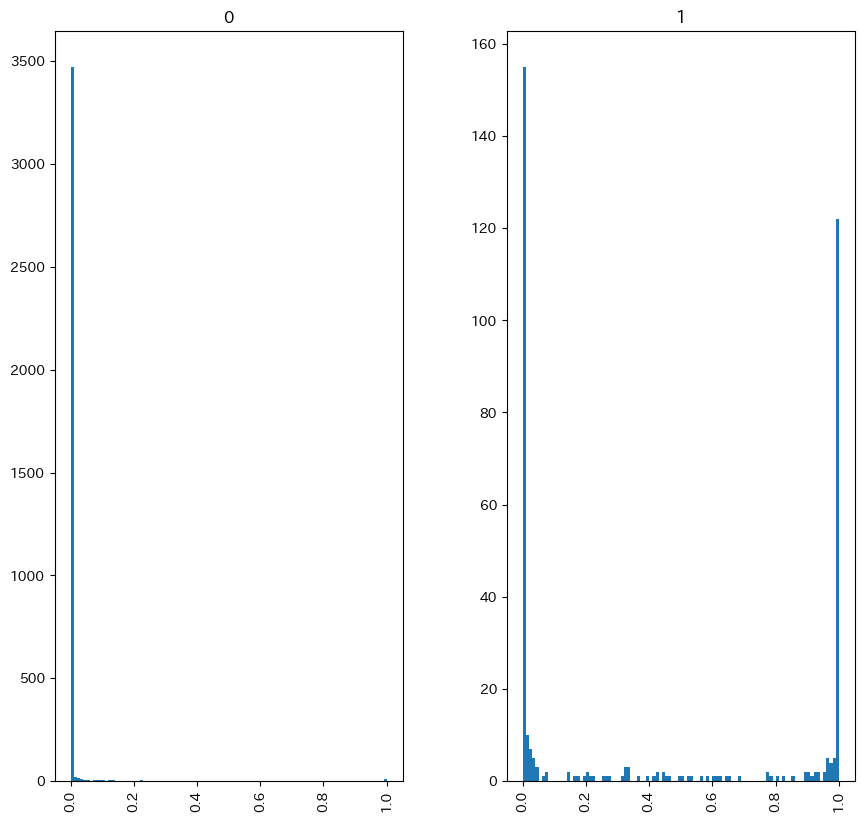

In [ ]:
# y_test, y_pred を結合して、y_test 毎に、y_pred のhistogramを作成
y_test_pred=pd.DataFrame({"y_test":y_val,"y_pred":y_pred})
y_test_pred["y_pred"].hist(by=y_test_pred["y_test"],bins=100,figsize=(10,10))

In [41]:
# テストデータで予測・評価
y_pred = model.predict(X_test, num_iteration=model.best_iteration,predict_disable_shape_check=True)
y_pred_trans = (y_pred > 0.5).astype(int)

# 評価
accuracy = accuracy_score(y_test, y_pred_trans)
precision = precision_score(y_test, y_pred_trans)
recall = recall_score(y_test, y_pred_trans)
f1 = f1_score(y_test, y_pred_trans)
auc=roc_auc_score(y_test, y_pred)

# 小数点2桁まで表示
pd.set_option('display.float_format', '{:.2f}'.format)
print('Accuracy:', accuracy, "Precision:", precision, "Recall:", recall, "F1:", f1,"AUC:",auc)

Accuracy: 0.9887843037040192 Precision: 0.12648112427666025 Recall: 0.22621981271562347 F1: 0.16224814422057265 AUC: 0.7549796085333517


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

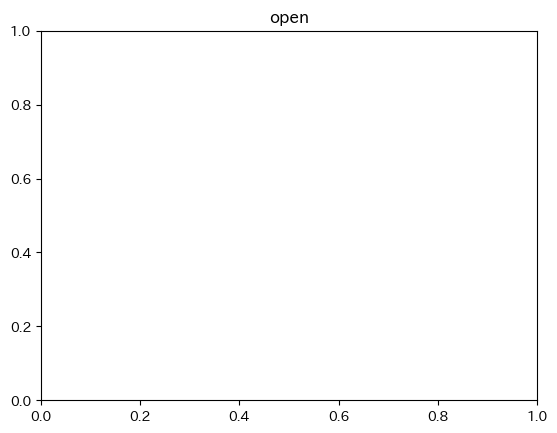

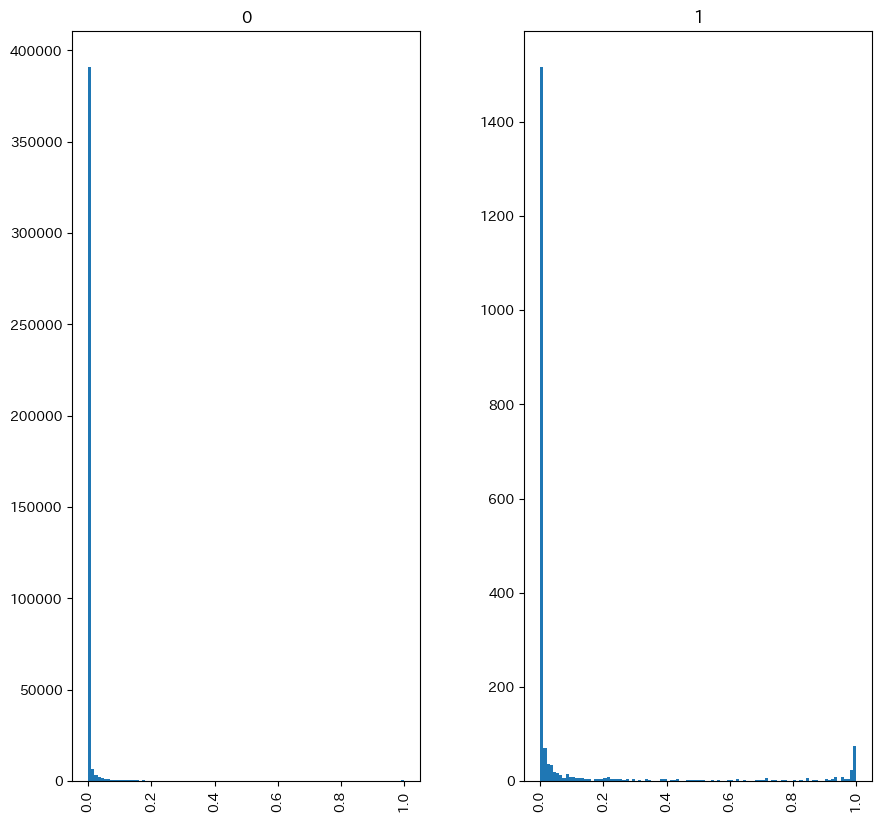

In [ ]:
# y_test, y_pred を結合して、y_test 毎に、y_pred のhistogramを作成
y_test_pred=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
plt.title("open")
y_test_pred["y_pred"].hist(by=y_test_pred["y_test"],bins=100,figsize=(10,10))



Text(0.5, 1.0, 'LightGBM Feature Importance (gain)')

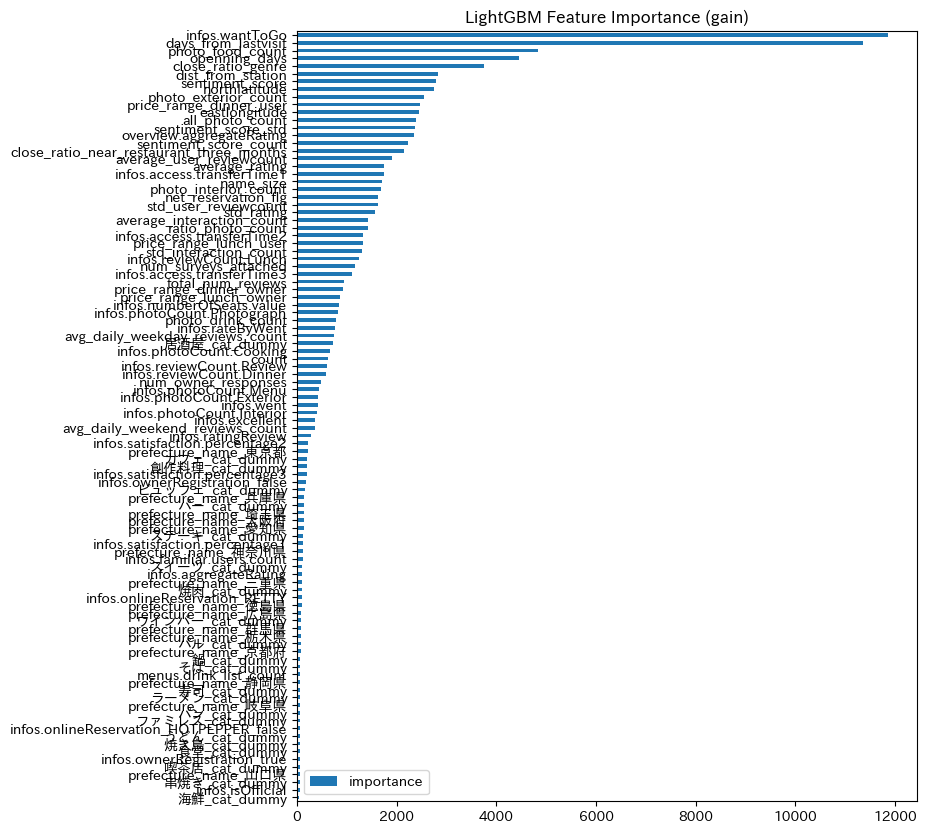

In [ ]:
# feature importance
# 日本語を表示するためにフォントを指定

importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=X.columns, columns=['importance'])
importance.sort_values('importance',ascending=False).head(100).sort_values('importance').plot(kind='barh', figsize=(8, 10))
plt.title('LightGBM Feature Importance (gain)')


In [ ]:
print(importance)

                                         importance
infos.wantToGo                             11851.94
infos.photoCount.Cooking                     654.15
price_range_dinner_user                     2460.00
infos.photoCount.Menu                        439.25
infos.photoCount.Exterior                    428.23
...                                             ...
infos.ticket_true                              0.94
infos.ownerRegistration_false                185.32
infos.ownerRegistration_true                  51.52
infos.onlineReservation_HOTPEPPER_false       56.44
infos.onlineReservation_HOTPEPPER_true        21.80

[340 rows x 1 columns]


In [ ]:
importance.sort_values(by="importance",ascending=False).head(30).index.values

array(['infos.wantToGo', 'days_from_lastvisit', 'photo_food_count',
       'openning_days', 'close_ratio_genre', 'dist_from_station',
       'sentiment_score', 'northlatitude', 'photo_exterior_count',
       'price_range_dinner_user', 'eastlongitude', 'all_photo_count',
       'sentiment_score_std', 'overview.aggregateRating',
       'sentiment_score_count',
       'close_ratio_near_restaurant_three_months',
       'average_user_reviewcount', 'average_rating',
       'infos.access.transferTime1', 'name_size', 'photo_interior_count',
       'net_reservation_flg', 'std_user_reviewcount', 'std_rating',
       'average_interaction_count', 'ratio_photo_count',
       'infos.access.transferTime2', 'price_range_lunch_user',
       'std_interaction_count', 'infos.reviewCount.Lunch'], dtype=object)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


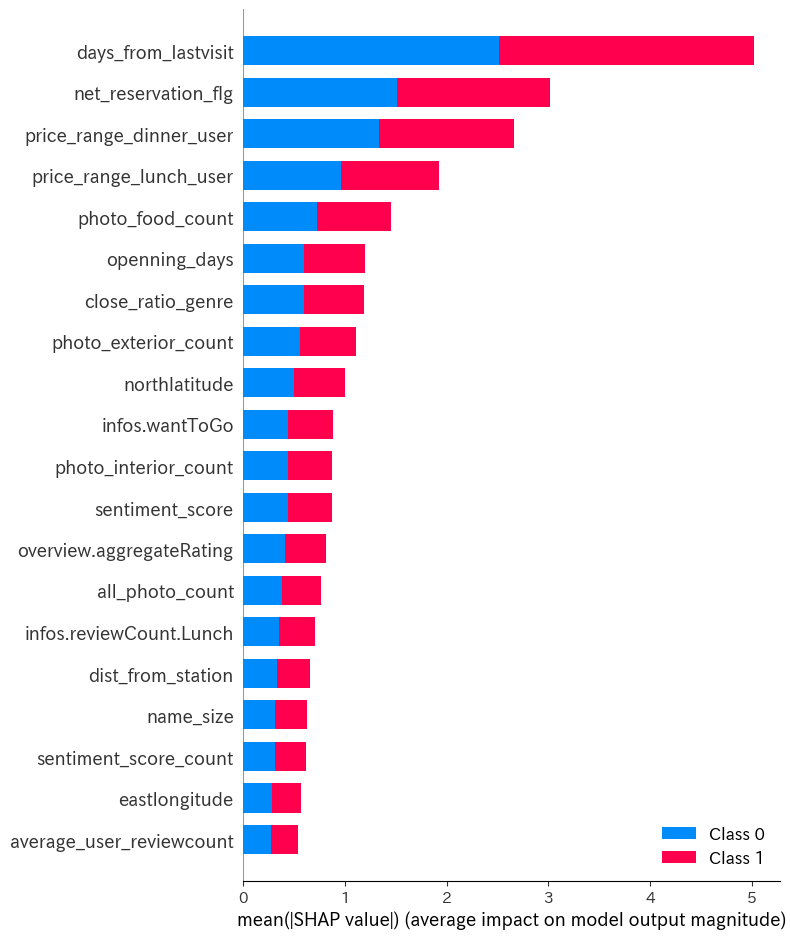

In [ ]:
# shap分析
import shap
shap.initjs()

explainer = shap.TreeExplainer(model=model)

X_test_shap = X_test.head(1000).copy().reset_index(drop=True)
shap_values = explainer.shap_values(X=X_test_shap)
# shap_values をplot
# サンプルごとのshap_valuesをplot
shap.summary_plot(shap_values, X_test_shap,max_display=20)

In [ ]:
%matplotlib inline
import matplotlib
matplotlib.use('TkAgg')  # または別のバックエンドを選択してください

X_test=X_test.head(1)

explainer = shap.Explainer(model, X_test)
shap_values = explainer.shap_values(X_test)

for i in range(len(X_test)):
    shap.initjs()  # Jupyter Notebookでの可視化を初期化する
    shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i,:])  # 各インスタンスのSHAP値をプロットする
    plt.show()  # プロットを表示する

ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running

In [ ]:
explainer.expected_value

-12.570596654155368

In [ ]:
shap_values[i]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
# 1. モデル shap.Explainer()に渡す
explainer = shap.Explainer(model)

X_test_shap = X_test.head(1000)

# 2. 説明変数(特徴量)を渡す
shap_values = explainer(X_test_shap)

In [ ]:
shap.plots.waterfall(shap_values[0])

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.